In [134]:
import os
import pandas as pd
import numpy as np
import mlflow
from mlflow.tracking import MlflowClient
from datetime import datetime
import re

In [135]:
# Configure MLflow client to read local experiment metadata

# Adjust if your mlruns is elsewhere
MLRUNS_DIR_CANDIDATES = [
    # "/home/zano/Documents/TESI/FOLDER_CINECA/notebooks/mlruns",
    "/home/zano/Documents/TESI/FOLDER_CINECA/mlruns"
]

# def pick_existing_dir(candidates):
#     for d in candidates:
#         if os.path.isdir(d):
#             return d
#     raise FileNotFoundError(f"No mlruns directory found in: {candidates}")

mlruns_dir = MLRUNS_DIR_CANDIDATES[0] #pick_existing_dir(MLRUNS_DIR_CANDIDATES)
tracking_uri = f"file://{mlruns_dir}"
mlflow.set_tracking_uri(tracking_uri)
client = MlflowClient()

experiments = client.search_experiments() 

# --- Configuration for Filtering ---
EXCLUDE_PARAM_KEYS = {"seed", "random_state"}
EXCLUDE_PARAM_PREFIXES = ["debug_", "temp_"]
EXCLUDE_PARAM_REGEX = [r"^unused_.*"]

# --CONFIG FOR METRIC FILTERING
EXCLUDE_METRIC_KEYS = {"train_loss_step", "val_loss_step"}
EXCLUDE_METRIC_PREFIXES = ["raw_", "tmp_"]
EXCLUDE_METRIC_REGEX = [r"val_fold",r".*loss*"]

# --- Data Loading ---
rows = []
for exp in experiments:
    exp_id = exp.experiment_id
    runs = client.search_runs([exp_id], max_results=1000)
    for run in runs:
        info = run.info
        data = run.data
        params = {f"param.{k}": v for k, v in data.params.items()}
        metrics = {f"metric.{k}": v for k, v in data.metrics.items()}
        tags = {f"tag.{k}": v for k, v in data.tags.items()}
        row = {
            "experiment_id": exp_id,
            "experiment_name": exp.name,
            "run_id": info.run_id,
            "run_name": data.tags.get("mlflow.runName", ""),
            "artifact_uri": info.artifact_uri,
        }
        row.update(params)
        row.update(metrics)
        row.update(tags)
        rows.append(row)

# --- DataFrame Creation and Filtering ---
df = pd.DataFrame(rows).sort_values(["experiment_name"])
print(df.shape)
print(df.info())

display(df)

(217, 204)
<class 'pandas.core.frame.DataFrame'>
Index: 217 entries, 55 to 203
Columns: 204 entries, experiment_id to metric.test_auc_fold_0
dtypes: float64(153), object(51)
memory usage: 347.5+ KB
None


,experiment_id,experiment_name,run_id,run_name,artifact_uri,param.use_crop,param.test_pat_ids_per_fold,param.crop_percentage,param.dropout_rate,param.creation_time,param.pretrained,param.num_channels,param.transfer_learning,param.intensity_augmentation_preset,param.val_counts,param.trainable_params,param.model_name,param.creation_date,param.best_lr,param.test_pat_ids_for_best_fold,param.batch_size,param.lr_discovery_folds,param.n_folds,param.best_fold_idx,param.weight_decay,param.lr_discovery_method,param.optimizer_name,param.mixup_alpha,param.total_params,param.test_counts,param.train_counts,param.model_library,param.epochs,param.freezed_layer_index,metric.mean_test_accuracy,metric.patient_major_mcc_formatted,metric.patient_major_recall_formatted,metric.mean_patient_soft_precision,metric.std_test_mcc,metric.std_patient_soft_mcc,metric.mean_patient_soft_recall,metric.mean_test_precision,metric.std_patient_soft_bal_acc,metric.mean_test_auc,metric.mean_patient_major_recall,metric.mean_patient_major_precision,metric.std_test_balanced_acc,metric.mean_patient_major_bal_acc,metric.std_test_auc,metric.exec_time_min,metric.std_patient_major_precision,metric.patient_major_precision_formatted,metric.std_patient_major_mcc,metric.mean_test_mcc,metric.std_test_f1,metric.std_test_loss,metric.patient_soft_mcc_formatted,metric.std_test_accuracy,metric.mean_test_balanced_acc,metric.mean_test_recall,metric.std_patient_major_recall,metric.mean_test_f1,metric.patient_major_bal_acc_formatted,metric.mean_patient_soft_bal_acc,metric.std_test_recall,metric.mean_patient_soft_mcc,metric.std_patient_soft_precision,metric.std_patient_major_bal_acc,metric.patient_soft_bal_acc_formatted,metric.std_patient_soft_recall,metric.std_test_precision,metric.patient_soft_precision_formatted,metric.mean_patient_major_mcc,metric.patient_soft_recall_formatted,metric.mean_test_loss,tag.patient_major_mcc_formatted,tag.mlflow.user,tag.mlflow.source.name,tag.patient_major_recall_formatted,tag.mlflow.runName,tag.patient_major_precision_formatted,tag.mlflow.source.type,tag.patient_soft_mcc_formatted,tag.mlflow.log-model.history,tag.patient_major_bal_acc_formatted,tag.mlflow.source.git.commit,tag.patient_soft_bal_acc_formatted,tag.patient_soft_precision_formatted,tag.patient_soft_recall_formatted,metric.val_fold_2/val_f1,metric.val_fold_2/val_mcc,metric.val_fold_2/val_precision,metric.val_fold_2/val_auc,metric.val_fold_2/val_recall,metric.val_fold_2/val_accuracy,metric.val_fold_2/val_balanced_accuracy,metric.val_fold_2/train_accuracy,metric.val_fold_2/train_loss,metric.val_fold_2/val_loss,metric.val_fold_5/val_f1,...,metric.val_fold_5/val_accuracy,metric.val_fold_5/val_balanced_accuracy,metric.val_fold_5/train_accuracy,metric.val_fold_5/train_loss,metric.val_fold_5/val_loss,metric.val_fold_3/val_f1,metric.val_fold_3/val_mcc,metric.val_fold_3/val_precision,metric.val_fold_3/val_auc,metric.val_fold_3/val_recall,metric.val_fold_3/val_accuracy,metric.val_fold_3/val_balanced_accuracy,metric.val_fold_3/train_accuracy,metric.val_fold_3/train_loss,metric.val_fold_3/val_loss,metric.val_fold_7/val_f1,metric.val_fold_7/val_mcc,metric.val_fold_7/val_precision,metric.val_fold_7/val_auc,metric.val_fold_7/val_recall,metric.val_fold_7/val_accuracy,metric.val_fold_7/val_balanced_accuracy,metric.val_fold_7/train_accuracy,metric.val_fold_7/train_loss,metric.val_fold_7/val_loss,metric.val_fold_6/val_f1,metric.val_fold_6/val_mcc,metric.val_fold_6/val_precision,metric.val_fold_6/val_auc,metric.val_fold_6/val_recall,metric.val_fold_6/val_accuracy,metric.val_fold_6/val_balanced_accuracy,metric.val_fold_6/train_accuracy,metric.val_fold_6/train_loss,metric.val_fold_6/val_loss,metric.val_fold_0/val_f1,metric.val_fold_0/val_mcc,metric.val_fold_0/val_precision,metric.val_fold_0/val_auc,metric.val_fold_0/val_recall,metric.val_fold_0/val_accuracy,metric.val_fold_0/val_balanced_accuracy,metric.val_fold_0/train_accuracy,metric.val_fold_0/train_loss,metric.val_fold_0/val_loss,metric.val_fold_1/val_f1,metric.

In [136]:
# Normalize empty values and compute column retention threshold

import numpy as np # Make sure numpy is imported

# Replace empty strings '' with the standard np.nan
df = df.replace('', np.nan)

import math # We'll need this to round up

# 1. Get the total number of rows (runs)
total_rows = len(df)

# 2. Calculate the threshold: 5% of total rows.
# This is the minimum *non-missing* values a column must have to be kept.
# We use math.ceil() to round up. e.g., if 5% is 10.8, we need at least 11 values.
min_non_nan_count = math.ceil(total_rows * 0.07)

print(f"Total rows: {total_rows}")
print(f"Columns will be KEPT if they have at least {min_non_nan_count} non-NaN values.")

# 3. Apply the drop
# Keep track of columns before for comparison
cols_before_drop = set(df.columns)

# axis='columns' applies this to columns, not rows
# thresh=... tells pandas the minimum *non-NaN* count to keep the column
df_cleaned = df.dropna(axis='columns', thresh=min_non_nan_count)

# 4. Report what happened
cols_after_drop = set(df.columns)
dropped_cols = cols_before_drop - cols_after_drop

print(f"\nDropped {len(dropped_cols)} columns with >95% missing values.")
if dropped_cols:
    print(f"Columns dropped: {list(dropped_cols)}")

# See the new shape
print(f"\nNew DataFrame shape: {df.shape}")

Total rows: 217
Columns will be KEPT if they have at least 16 non-NaN values.

Dropped 0 columns with >95% missing values.

New DataFrame shape: (217, 204)


In [137]:
df.columns.tolist()

['experiment_id',
 'experiment_name',
 'run_id',
 'run_name',
 'artifact_uri',
 'param.use_crop',
 'param.test_pat_ids_per_fold',
 'param.crop_percentage',
 'param.dropout_rate',
 'param.creation_time',
 'param.pretrained',
 'param.num_channels',
 'param.transfer_learning',
 'param.intensity_augmentation_preset',
 'param.val_counts',
 'param.trainable_params',
 'param.model_name',
 'param.creation_date',
 'param.best_lr',
 'param.test_pat_ids_for_best_fold',
 'param.batch_size',
 'param.lr_discovery_folds',
 'param.n_folds',
 'param.best_fold_idx',
 'param.weight_decay',
 'param.lr_discovery_method',
 'param.optimizer_name',
 'param.mixup_alpha',
 'param.total_params',
 'param.test_counts',
 'param.train_counts',
 'param.model_library',
 'param.epochs',
 'param.freezed_layer_index',
 'metric.mean_test_accuracy',
 'metric.patient_major_mcc_formatted',
 'metric.patient_major_recall_formatted',
 'metric.mean_patient_soft_precision',
 'metric.std_test_mcc',
 'metric.std_patient_soft_mcc',


In [138]:
# Explicitly list the correct columns to drop as a Python list of strings.
cols_to_drop = [
    "tag.mlflow.runName",
    "tag.mlflow.source.git.commit",
    "tag.mlflow.source.name",
    "tag.mlflow.source.type",
    "tag.mlflow.user",
    "tag.mlflow.log-model.history",
    "param.fine_tuning"
]

df = df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns: {cols_to_drop}")
print(f"New DataFrame shape: {df.shape}")
# Drop parameter and metric columns flagged by exclusion rules

Dropped 7 columns: ['tag.mlflow.runName', 'tag.mlflow.source.git.commit', 'tag.mlflow.source.name', 'tag.mlflow.source.type', 'tag.mlflow.user', 'tag.mlflow.log-model.history', 'param.fine_tuning']
New DataFrame shape: (217, 197)


In [139]:
# Drop parameter and metric columns flagged by exclusion rules

param_cols_to_drop = []
for col in df.columns:
    if col.startswith("param."):
        param_name = col.replace("param.", "", 1)
        if (param_name in EXCLUDE_PARAM_KEYS or
            any(param_name.startswith(p) for p in EXCLUDE_PARAM_PREFIXES) or
            any(re.search(rx, param_name) for rx in EXCLUDE_PARAM_REGEX)):
            param_cols_to_drop.append(col)

metric_cols_to_drop = []
for col in df.columns:
    if col.startswith("metric."):
        metric_name = col.replace("metric.", "", 1)
        if (metric_name in EXCLUDE_METRIC_KEYS or
            any(metric_name.startswith(p) for p in EXCLUDE_METRIC_PREFIXES) or
            any(re.search(rx, metric_name) for rx in EXCLUDE_METRIC_REGEX)):
            metric_cols_to_drop.append(col)

cols_to_drop = param_cols_to_drop + metric_cols_to_drop
df.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped {len(cols_to_drop)} parameter/metric columns based on exclusion rules.")
print(df.shape)

# #drop columns with loss in their name
# loss_cols = [col for col in df.columns if 'loss' in col.lower()]
# df.drop(columns=loss_cols, inplace=True, errors='ignore')
# print(f"Dropped {len(loss_cols)} columns containing 'loss': {loss_cols}")
# print(df.shape)

print(f"After filtering, {len(df)} runs remain with experiment names starting with 'SL' or 'pretrained'")


Dropped 82 parameter/metric columns based on exclusion rules.
(217, 115)
After filtering, 217 runs remain with experiment names starting with 'SL' or 'pretrained'


In [140]:
# Filter runs to the target experiment families before analysis

# Create a boolean mask for rows to keep
# keep only rows with experiment name starting with SL, pretrained, or DS
mask = (df['experiment_name'].str.startswith('SL', na=False) |
        df['experiment_name'].str.startswith('pretrained', na=False) |
        df['experiment_name'].str.startswith('DS', na=False))

# Apply the filter
n_cols_before = len(df.columns)
df = df[mask]
n_cols_after = len(df.columns)
print(f"Dropped {n_cols_before - n_cols_after} columns")
print(df.shape)

Dropped 0 columns
(212, 115)


In [141]:
# Remove fold-specific metrics to focus on aggregated results

import re

# 1. Compile a regex pattern to find 'fold_' + one or more digits
pattern = re.compile(r'fold_\d+')
# 2. Build a list of columns where the pattern is found ANYWHERE
columns_to_drop = [col for col in df.columns if pattern.search(col)]
# 3. Drop the identified columns
df = df.drop(columns=columns_to_drop)

print(f"Dropping {len(columns_to_drop)} columns containing 'fold': {columns_to_drop}")
# 2. Drop the identified columns

Dropping 32 columns containing 'fold': ['metric.test_recall_fold_4', 'metric.test_precision_fold_0', 'metric.test_recall_fold_1', 'metric.test_mcc_fold_0', 'metric.test_recall_fold_6', 'metric.test_auc_fold_3', 'metric.test_recall_fold_0', 'metric.test_auc_fold_4', 'metric.test_precision_fold_3', 'metric.test_mcc_fold_7', 'metric.test_auc_fold_2', 'metric.test_mcc_fold_3', 'metric.test_precision_fold_4', 'metric.test_mcc_fold_4', 'metric.test_mcc_fold_6', 'metric.test_precision_fold_6', 'metric.test_precision_fold_7', 'metric.test_recall_fold_3', 'metric.test_auc_fold_1', 'metric.test_mcc_fold_1', 'metric.test_precision_fold_1', 'metric.test_recall_fold_2', 'metric.test_recall_fold_5', 'metric.test_mcc_fold_5', 'metric.test_mcc_fold_2', 'metric.test_precision_fold_5', 'metric.test_precision_fold_2', 'metric.test_auc_fold_7', 'metric.test_auc_fold_6', 'metric.test_recall_fold_7', 'metric.test_auc_fold_5', 'metric.test_auc_fold_0']


## ADDING NEW COLUMNS

In [142]:
import ast

def fold0(x):
    try:
        if isinstance(x, str):
            x = ast.literal_eval(x)
        return (x or {}).get(0, (x or {}).get('0'))
    except Exception:
        return None

test_lt25 = pd.to_numeric(df.get('param.test_counts'), errors='coerce').lt(25)
val0_lt25 = pd.to_numeric(df.get('param.val_counts', pd.Series(index=df.index)).apply(fold0),
                          errors='coerce').lt(25)

df['dataset'] = np.where(test_lt25 | val0_lt25, 'DS1', 'DS2')

check = df.loc[test_lt25 | val0_lt25, ['param.test_counts', 'param.val_counts', 'dataset']].head(10)
display(check)

# 4) Rule consistency: all rows meeting the rule must be DS1
assert (df.loc[test_lt25 | val0_lt25, 'dataset'] == 'DS1').all(), "Rule violation: DS1 expected"

# 5) Optional: rows labeled DS2 should not meet either condition
violations = df.loc[(df['dataset'] == 'DS2') & (test_lt25 | val0_lt25),
                    ['param.test_counts', 'param.val_counts', 'dataset']]
display(violations)
assert violations.empty, "Found DS2 rows that meet DS1 rule"

,param.test_counts,param.val_counts,dataset
55,14,"{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",DS1
54,14,"{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",DS1
53,14,"{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",DS1
52,14,"{0: 19, 1: 19, 2: 19, 3: 19, 4: 19, 5: 19, 6: ...",DS1
51,"{'fold_0': 8, 'fold_1': 8, 'fold_2': 8, 'fold_...","{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",DS1
20,"{'fold_0': 11, 'fold_1': 11, 'fold_2': 11, 'fo...","{0: 22, 1: 22, 2: 22, 3: 22, 4: 22, 5: 22, 6: ...",DS1
23,20,"{0: 22, 1: 22, 2: 22, 3: 22, 4: 22, 5: 22, 6: ...",DS1
22,20,"{0: 22, 1: 22, 2: 22, 3: 22, 4: 22, 5: 22, 6: ...",DS1
21,20,"{0: 25, 1: 25, 2: 25, 3: 25, 4: 25, 5: 25, 6: ...",DS1
49,14,"{0: 21, 1: 20, 2: 20, 3: 21, 4: 21, 5: 21, 6: ...",DS1


,param.test_counts,param.val_counts,dataset


In [143]:
# Infer num_channels using logged params with an experiment-based fallback

# Step 1: Create the fallback values for all rows based on the original inference logic.
print("Inferring fallback 'num_channels' for all rows...")
condition_3c = df['experiment_name'].str.contains("3c", na=False)

if 'param.transfer_learning' in df.columns:
    condition_tl = (df['param.transfer_learning'] == 'True')
else:
    condition_tl = pd.Series([False] * len(df), index=df.index)
    print("Warning: 'param.transfer_learning' column not found for fallback. Assuming False.")

is_3_channels = condition_3c | condition_tl
fallback_channels = pd.Series(np.where(is_3_channels, 3, 4), index=df.index)

# Step 2: Use 'param.num_channels' as the priority source, and fill any missing values with the fallback.
if 'param.num_channels' in df.columns:
    print("Found 'param.num_channels'. Using it as priority, with inference as fallback.")
    # Convert the parameter column to numeric, forcing errors into NaN (Not a Number)
    priority_channels = pd.to_numeric(df['param.num_channels'], errors='coerce')
    # Use the priority values, and for any NaNs, fill with the corresponding value from the fallback Series.
    df['num_channels'] = priority_channels.fillna(fallback_channels)
else:
    print("Did not find 'param.num_channels'. Creating 'num_channels' based on inference only.")
    df['num_channels'] = fallback_channels

# Ensure the final column is an integer type, as channel counts are whole numbers.
df['num_channels'] = df['num_channels'].astype(int)
print("Added 'num_channels' column with priority-fallback logic.")

Inferring fallback 'num_channels' for all rows...
Found 'param.num_channels'. Using it as priority, with inference as fallback.
Added 'num_channels' column with priority-fallback logic.


In [144]:
# Create class labels and correct mislogged color transform flags
# Create a condition to check if the experiment name contains the specific substring
condition_msap = df['experiment_name'].str.contains("_MSA-P_vs_PD_", na=False)

# Use np.where to assign the value based on the condition
df['classes'] = np.where(condition_msap, 'MSA-P vs PD', 'MSA vs PD')
print("Added 'classes' column based on experiment name.")

Added 'classes' column based on experiment name.


In [145]:
# --- Correct param.color_transforms based on run_name due to error in logging code---
if 'run_name' in df.columns and 'param.color_transforms' in df.columns:
    # Create a boolean mask for rows where run_name contains the specific string
    color_transform_mask = df['run_name'].str.contains('_color_transforms:True_', na=False)

    # Update the 'param.color_transforms' column to True where the mask is True
    df.loc[color_transform_mask, 'param.color_transforms'] = 'True'
    print("Updated 'param.color_transforms' based on 'run_name' content.")

# --- Create, Display, and Save Final Merged Table ---
# The main 'df' DataFrame now contains all info. We will reorder it for better readability.
# Define the desired column order, including the new 'classes' column
id_cols = ['experiment_name', 'run_name', 'dataset', 'classes', 'num_channels']
tag_cols = sorted([c for c in df.columns if c.startswith("tag.")])
# Exclude the original param.num_channels from the list of param columns to avoid redundancy
param_cols = sorted([
    c for c in df.columns# def pick_existing_dir(candidates):
#     for d in candidates:
#         if os.path.isdir(d):
#             return d
#     raise FileNotFoundError(f"No mlruns directory found in: {candidates}")
    if c.startswith("param.") and c != 'param.num_channels'
])
metric_cols = sorted([c for c in df.columns if c.startswith("metric.")])

# Construct the final list of columns, ensuring they exist in the DataFrame
final_cols_order = [col for col in id_cols if col in df.columns] + \
                   [col for col in param_cols if col in df.columns] + \
                   [col for col in metric_cols if col in df.columns]+\
                    [col for col in tag_cols if col in df.columns]
# Create the final, reordered dataframe
results_df = df[final_cols_order].copy()

# Replace 'torchvision' with 'imagenet' in the 'param.pretrained' column
if 'param.pretrained' in results_df.columns:
    results_df['param.pretrained'] = results_df['param.pretrained'].replace('torchvision', 'imagenet')
    print("Replaced 'torchvision' with 'imagenet' in 'param.pretrained' column.")

pd.set_option("display.max_columns", 200)
print("\n--- Final Merged Results Table ---")
# Use display() if in a notebook environment, otherwise print()
try:
    display(results_df)
except NameError:
    print(results_df)


Updated 'param.color_transforms' based on 'run_name' content.
Replaced 'torchvision' with 'imagenet' in 'param.pretrained' column.

--- Final Merged Results Table ---


,experiment_name,run_name,dataset,classes,num_channels,param.batch_size,param.best_fold_idx,param.best_lr,param.color_transforms,param.creation_date,param.creation_time,param.crop_percentage,param.dropout_rate,param.epochs,param.freezed_layer_index,param.intensity_augmentation_preset,param.lr_discovery_folds,param.lr_discovery_method,param.mixup_alpha,param.model_library,param.model_name,param.n_folds,param.optimizer_name,param.pretrained,param.test_counts,param.test_pat_ids_for_best_fold,param.test_pat_ids_per_fold,param.total_params,param.train_counts,param.trainable_params,param.transfer_learning,param.use_crop,param.use_lr_discovery,param.val_counts,param.weight_decay,metric.exec_time_min,metric.mean_patient_major_bal_acc,metric.mean_patient_major_mcc,metric.mean_patient_major_precision,metric.mean_patient_major_recall,metric.mean_patient_soft_bal_acc,metric.mean_patient_soft_mcc,metric.mean_patient_soft_precision,metric.mean_patient_soft_recall,metric.mean_test_accuracy,metric.mean_test_auc,metric.mean_test_balanced_acc,metric.mean_test_f1,metric.mean_test_mcc,metric.mean_test_precision,metric.mean_test_recall,metric.patient_major_bal_acc_formatted,metric.patient_major_mcc_formatted,metric.patient_major_precision_formatted,metric.patient_major_recall_formatted,metric.patient_soft_bal_acc_formatted,metric.patient_soft_mcc_formatted,metric.patient_soft_precision_formatted,metric.patient_soft_recall_formatted,metric.std_patient_major_bal_acc,metric.std_patient_major_mcc,metric.std_patient_major_precision,metric.std_patient_major_recall,metric.std_patient_soft_bal_acc,metric.std_patient_soft_mcc,metric.std_patient_soft_precision,metric.std_patient_soft_recall,metric.std_test_accuracy,metric.std_test_auc,metric.std_test_balanced_acc,metric.std_test_f1,metric.std_test_mcc,metric.std_test_precision,metric.std_test_recall,tag.patient_major_bal_acc_formatted,tag.patient_major_mcc_formatted,tag.patient_major_precision_formatted,tag.patient_major_recall_formatted,tag.patient_soft_bal_acc_formatted,tag.patient_soft_mcc_formatted,tag.patient_soft_precision_formatted,tag.patient_soft_recall_formatted
55,DS1_3c_MSA-P_vs_PD_supervised,Densenet121_oversamp_torchvision_10-13_at:22-0...,DS1,MSA-P vs PD,3,32,NaN,0.00012207764786954147,NaN,10-13,22:09:14,0.95,0.2,150,None,light,4,nested,0,torchvision,Densenet121,8,AdamW,imagenet,14,NaN,NaN,6955906,"{0: 92, 1: 93, 2: 91, 3: 91, 4: 91, 5: 90, 6: ...",6955906,False,False,NaN,"{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",1e-4,52.304000,0.656,0.347,0.549,0.750,0.656,0.318,0.562,0.688,0.676000,0.748000,0.663000,0.625000,0.339000,0.565000,0.703000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.136,0.288,0.231,0.331,0.205,0.419,0.263,0.325,0.121000,0.173000,0.131000,0.261000,0.273000,0.234000,0.299000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,DS1_3c_MSA-P_vs_PD_supervised,Densenet169_mixup0.2_oversamp_torchvision_10-1...,DS1,MSA-P vs PD,3,32,NaN,0.00012207764786954147,NaN,10-14,00:00:35,0.95,0.2,150,None,light,4,nested,0.2,torchvision,Densenet169,8,AdamW,imagenet,14,NaN,NaN,12487810,"{0: 92, 1: 93, 2: 91, 3: 91, 4: 91, 5: 90, 6: ...",12487810,False,False,NaN,"{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",1e-4,64.841000,0.700,0.433,0.594,0.844,0.692,0.395,0.629,0.771,0.667000,0.732000,0.672000,0.686000,0.360000,0.615000,0.792000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.198,0.420,0.258,0.329,0.161,0.333,0.169,0.235,0.189000,0.177000,0.185000,0.197000,0.382000,0.173000,0.240000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,DS1_3c_MSA-P_vs_PD_supervised,Densenet169_oversamp_torchvision_10-14_at:11-5...,DS1,MSA-P vs PD,3,32,NaN,0.00012207764786954147,NaN,10-14,11:55:02,0.95,0.2,150,None,light,4,nested,0,torchvision,Densenet169,8,AdamW,imagenet,14,NaN,NaN,12487810,"{0: 92, 1: 93, 2: 91, 3: 91, 4: 91, 5: 90, 6: ...",12487810,False,False,NaN,"{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",1e-4,57.341000,0.716,0.483,0.625,0.906,0.728,0.487,0.638,0.875,0.682000,0.737000,0.688000,0.708000,0.394000,0.630000,0.823000,NaN,NaN,NaN,NaN,Na

In [146]:
import numpy as np
import pandas as pd # Make sure pandas and numpy are imported

print("\n--- Filling missing formatted tag values ---")

# The 8 tag columns you want to fill
tag_cols_to_fill = [
    "tag.patient_major_bal_acc_formatted",
    "tag.patient_major_mcc_formatted",
    "tag.patient_major_precision_formatted",
    "tag.patient_major_recall_formatted",
    "tag.patient_soft_bal_acc_formatted",
    "tag.patient_soft_mcc_formatted",
    "tag.patient_soft_precision_formatted",
    "tag.patient_soft_recall_formatted"
]

# We are modifying results_df, which is a .copy()
# so we are safe from SettingWithCopyWarning
df_to_update = results_df 

# Loop through each of the 8 tag columns
for tag_col in tag_cols_to_fill:
    
    # 1. Derive the mean/std column names from the tag name
    # "tag.patient_major_bal_acc_formatted" -> "patient_major_bal_acc"
    base_name = tag_col.replace('tag.', '').replace('_formatted', '')
    
    # -> "metric.mean_patient_major_bal_acc"
    mean_col = f"metric.mean_{base_name}" 
    # -> "metric.std_patient_major_bal_acc"
    std_col = f"metric.std_{base_name}"
    
    # 2. Check if these source columns actually exist in our DataFrame
    if mean_col in df_to_update.columns and std_col in df_to_update.columns:
        
        # 3. Create a mask to find the rows to fill
        # We want rows where:
        #   - The tag column IS missing (NaN)
        #   - The mean_col IS NOT missing
        #   - The std_col IS NOT missing
        mask = (
            df_to_update[tag_col].isna() & #se la colonna tag è vuota
            df_to_update[mean_col].notna() & #se la colonna metric mean corrispondente non è vuota
            df_to_update[std_col].notna() #se la colonna metric std corrispondente non è vuota
        )
        
        # If we found any rows to fill...
        if mask.sum() > 0:
            
            # 4. Format the strings for just those rows
            # We use .loc[mask] to only select the rows we care about
            
            # Get the mean/std values, round to 3 decimals, convert to string
            mean_values = df_to_update.loc[mask, mean_col].round(3).astype(str)
            std_values = df_to_update.loc[mask, std_col].round(3).astype(str)
            
            # Combine them into the "mean ± std" format
            formatted_strings = mean_values + " ± " + std_values
            
            # 5. Use .loc to assign these new strings back to the DataFrame
            # This is the correct, warning-free way to do it.
            df_to_update.loc[mask, tag_col] = formatted_strings
            
            print(f"Filled {mask.sum()} missing values in {tag_col}")
    else:
        print(f"Skipped {tag_col}: Source columns not found.")

print("--- Finished filling tags ---")

# --- Now you can proceed to save ---
# (You might want to display the head to check)
print("\nChecking the first few rows of the filled tags:")
try:
    display(results_df[tag_cols_to_fill].head())
except NameError:
    print(results_df[tag_cols_to_fill].head())



--- Filling missing formatted tag values ---
Filled 43 missing values in tag.patient_major_bal_acc_formatted
Filled 42 missing values in tag.patient_major_mcc_formatted
Filled 42 missing values in tag.patient_major_precision_formatted
Filled 42 missing values in tag.patient_major_recall_formatted
Filled 43 missing values in tag.patient_soft_bal_acc_formatted
Filled 42 missing values in tag.patient_soft_mcc_formatted
Filled 42 missing values in tag.patient_soft_precision_formatted
Filled 42 missing values in tag.patient_soft_recall_formatted
--- Finished filling tags ---

Checking the first few rows of the filled tags:


,tag.patient_major_bal_acc_formatted,tag.patient_major_mcc_formatted,tag.patient_major_precision_formatted,tag.patient_major_recall_formatted,tag.patient_soft_bal_acc_formatted,tag.patient_soft_mcc_formatted,tag.patient_soft_precision_formatted,tag.patient_soft_recall_formatted
55,0.656 ± 0.136,0.347 ± 0.288,0.549 ± 0.231,0.75 ± 0.331,0.656 ± 0.205,0.318 ± 0.419,0.562 ± 0.263,0.688 ± 0.325
54,0.7 ± 0.198,0.433 ± 0.42,0.594 ± 0.258,0.844 ± 0.329,0.692 ± 0.161,0.395 ± 0.333,0.629 ± 0.169,0.771 ± 0.235
53,0.716 ± 0.164,0.483 ± 0.329,0.625 ± 0.166,0.906 ± 0.248,0.728 ± 0.159,0.487 ± 0.33,0.638 ± 0.156,0.875 ± 0.25
52,0.683 ± 0.158,0.384 ± 0.324,0.64 ± 0.18,0.76 ± 0.23,0.727 ± 0.165,0.471 ± 0.331,0.685 ± 0.155,0.792 ± 0.243
51,0.738 ± 0.204,0.498 ± 0.412,0.735 ± 0.221,0.75 ± 0.28,0.75 ± 0.165,0.522 ± 0.335,0.746 ± 0.18,0.781 ± 0.263


In [147]:
import numpy as np # Make sure np is imported

df_to_update = results_df

# 1. Define the base names for the 'test' metrics
base_metric_names = [
    'test_accuracy',
    'test_auc',
    'test_balanced_acc',
    'test_f1',
    'test_mcc',
    'test_precision',
    'test_recall'
]

print("\n--- Creating formatted 'test' metric columns (Corrected Version) ---")

for col in base_metric_names:
    
    mean_col_name = f"metric.mean_{col}"
    std_col_name = f"metric.std_{col}"
    
    # Let's create the new column name (I'll add the 'metric.' prefix 
    # to be consistent with your other columns, but f"{col}_formatted" also works!)
    new_formatted_col = f"metric.{col}_formatted"
    
    # --- THIS IS THE ROBUST PATTERN ---
    
    # 1. Create the new column and fill it with NaN
    # This ensures it exists, even if there's no data.
    df_to_update[new_formatted_col] = np.nan
    
    # 2. Check if source columns exist
    if mean_col_name in df_to_update.columns and std_col_name in df_to_update.columns:
        
        # 3. Create the mask
        mask = (
            df_to_update[mean_col_name].notna() &
            df_to_update[std_col_name].notna()
        )
        
        # 4. Check if there's anything to fill
        if mask.sum() > 0: #if both mean and std are not missing
            
            # **FIX 1:** Use the correct variable names
            mean_values = df_to_update.loc[mask, mean_col_name].round(3).astype(str)
            std_values = df_to_update.loc[mask, std_col_name].round(3).astype(str)
        
            # **FIX 2:** Assign the new values *only* to the masked rows
            # in the new column using .loc
            df_to_update.loc[mask, new_formatted_col] = mean_values + " ± " + std_values
            
            print(f"Created {new_formatted_col} with {mask.sum()} values.")
    else:
        print(f"Skipped {new_formatted_col}: Source columns not found.")

print("--- Finished creating 'test' formatted metrics ---")


--- Creating formatted 'test' metric columns (Corrected Version) ---
Created metric.test_accuracy_formatted with 212 values.
Created metric.test_auc_formatted with 212 values.
Created metric.test_balanced_acc_formatted with 212 values.
Created metric.test_f1_formatted with 212 values.
Created metric.test_mcc_formatted with 212 values.
Created metric.test_precision_formatted with 212 values.
Created metric.test_recall_formatted with 212 values.
--- Finished creating 'test' formatted metrics ---


/tmp/ipykernel_343403/3426685469.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0.676 ± 0.121' '0.667 ± 0.189' '0.682 ± 0.163' '0.696 ± 0.146'
 '0.745 ± 0.16' '0.679 ± 0.098' '0.541 ± 0.147' '0.616 ± 0.139'
 '0.693 ± 0.124' '0.754 ± 0.118' '0.742 ± 0.137' '0.733 ± 0.134'
 '0.776 ± 0.15' '0.783 ± 0.056' '0.705 ± 0.08' '0.779 ± 0.157'
 '0.64 ± 0.092' '0.663 ± 0.117' '0.663 ± 0.132' '0.665 ± 0.15'
 '0.665 ± 0.141' '0.669 ± 0.13' '0.609 ± 0.129' '0.576 ± 0.12'
 '0.635 ± 0.133' '0.586 ± 0.152' '0.576 ± 0.115' '0.675 ± 0.078'
 '0.562 ± 0.126' '0.663 ± 0.116' '0.585 ± 0.089' '0.695 ± 0.121'
 '0.683 ± 0.077' '0.666 ± 0.133' '0.687 ± 0.086' '0.571 ± 0.139'
 '0.622 ± 0.087' '0.571 ± 0.095' '0.633 ± 0.136' '0.64 ± 0.114'
 '0.633 ± 0.045' '0.547 ± 0.079' '0.518 ± 0.124' '0.653 ± 0.149'
 '0.7 ± 0.157' '0.626 ± 0.159' '0.681 ± 0.172' '0.645 ± 0.159'
 '0.701 ± 0.154' '0.663 ± 0.107' '0.651 ± 0.091' '0.656 ± 0.0

In [148]:
results_df.columns.tolist()

['experiment_name',
 'run_name',
 'dataset',
 'classes',
 'num_channels',
 'param.batch_size',
 'param.best_fold_idx',
 'param.best_lr',
 'param.color_transforms',
 'param.creation_date',
 'param.creation_time',
 'param.crop_percentage',
 'param.dropout_rate',
 'param.epochs',
 'param.freezed_layer_index',
 'param.intensity_augmentation_preset',
 'param.lr_discovery_folds',
 'param.lr_discovery_method',
 'param.mixup_alpha',
 'param.model_library',
 'param.model_name',
 'param.n_folds',
 'param.optimizer_name',
 'param.pretrained',
 'param.test_counts',
 'param.test_pat_ids_for_best_fold',
 'param.test_pat_ids_per_fold',
 'param.total_params',
 'param.train_counts',
 'param.trainable_params',
 'param.transfer_learning',
 'param.use_crop',
 'param.use_lr_discovery',
 'param.val_counts',
 'param.weight_decay',
 'metric.exec_time_min',
 'metric.mean_patient_major_bal_acc',
 'metric.mean_patient_major_mcc',
 'metric.mean_patient_major_precision',
 'metric.mean_patient_major_recall',
 'metr

In [149]:
# Your list of prefixes to remove
prefixes_to_remove = ['metric.', 'param.', 'tag.']

# This will hold our new, clean column names
new_column_names = []

# Loop through every column name in your DataFrame
for col in results_df.columns:
    
    # Inner loop: check against each prefix
    for prefix in prefixes_to_remove:
        if col.startswith(prefix):
            # If it matches, slice the prefix off
            # e.g., 'metric.f1' becomes 'f1'
            new_name = col[len(prefix):]
            new_column_names.append(new_name)
            # Found a match, break out of the inner loop
            break
    else:
        # This 'else' block runs ONLY if the 'for' loop
        # finished without a 'break'.
        # This means no prefix was found, so we keep the original name.
        new_column_names.append(col)

# Now, assign the list of new names back to the DataFrame
results_df.columns = new_column_names

print("Renamed columns by removing prefixes.")
print("\nNew columns:", results_df.columns.tolist())

Renamed columns by removing prefixes.

New columns: ['experiment_name', 'run_name', 'dataset', 'classes', 'num_channels', 'batch_size', 'best_fold_idx', 'best_lr', 'color_transforms', 'creation_date', 'creation_time', 'crop_percentage', 'dropout_rate', 'epochs', 'freezed_layer_index', 'intensity_augmentation_preset', 'lr_discovery_folds', 'lr_discovery_method', 'mixup_alpha', 'model_library', 'model_name', 'n_folds', 'optimizer_name', 'pretrained', 'test_counts', 'test_pat_ids_for_best_fold', 'test_pat_ids_per_fold', 'total_params', 'train_counts', 'trainable_params', 'transfer_learning', 'use_crop', 'use_lr_discovery', 'val_counts', 'weight_decay', 'exec_time_min', 'mean_patient_major_bal_acc', 'mean_patient_major_mcc', 'mean_patient_major_precision', 'mean_patient_major_recall', 'mean_patient_soft_bal_acc', 'mean_patient_soft_mcc', 'mean_patient_soft_precision', 'mean_patient_soft_recall', 'mean_test_accuracy', 'mean_test_auc', 'mean_test_balanced_acc', 'mean_test_f1', 'mean_test_mcc

In [150]:
# Save the single, merged DataFrame to a CSV file
results_df.to_csv("mlflow_results_merged.csv", index=False)
print("\nSaved the final merged table to 'mlflow_results_merged.csv'")

print(f"\nLoaded and processed {len(df)} runs from {len(experiments)} experiments at {tracking_uri}")


Saved the final merged table to 'mlflow_results_merged.csv'

Loaded and processed 212 runs from 38 experiments at file:///home/zano/Documents/TESI/FOLDER_CINECA/mlruns


In [151]:
results_df.columns.tolist()
cols_to_drop = ['crop_percentage','n_folds']
results_df = results_df.drop(columns=cols_to_drop)

In [152]:
# 1. Define the list of "good" values we want to keep
lr_discovery_method_values = ['nested', 'nested_cv']

# 2. Create a mask for the rows to KEEP
#    Keep a row if:
#    (A) Its value is in our 'good_values' list
#    OR
#    (B) Its value is NaN (empty)
mask_to_keep = (
    results_df['lr_discovery_method'].isin(lr_discovery_method_values) |
    results_df['lr_discovery_method'].isna()
)

# 3. Overwrite the DataFrame with only the rows we want to keep
original_rows = len(results_df)

# We select all rows where our "keep" mask is True
results_df = results_df[mask_to_keep] 

new_rows = len(results_df)

print(f"Kept rows: {new_rows}. Dropped {original_rows - new_rows} rows.")

Kept rows: 211. Dropped 1 rows.


In [153]:
# drop colums with empty "creation_time"
rows_before = len(results_df)

# Drop rows where 'creation_time' is NaN (empty)
results_df = results_df.dropna(subset=['creation_time','best_lr']) #, 'best_fold_idx'

# See how many rows you have after
rows_after = len(results_df)

print(f"Dropped {rows_before - rows_after} rows with an empty 'creation_time'.")
print(f"New DataFrame shape: {results_df.shape}")

Dropped 155 rows with an empty 'creation_time'.
New DataFrame shape: (56, 87)


In [154]:
results_df.columns.tolist()

['experiment_name',
 'run_name',
 'dataset',
 'classes',
 'num_channels',
 'batch_size',
 'best_fold_idx',
 'best_lr',
 'color_transforms',
 'creation_date',
 'creation_time',
 'dropout_rate',
 'epochs',
 'freezed_layer_index',
 'intensity_augmentation_preset',
 'lr_discovery_folds',
 'lr_discovery_method',
 'mixup_alpha',
 'model_library',
 'model_name',
 'optimizer_name',
 'pretrained',
 'test_counts',
 'test_pat_ids_for_best_fold',
 'test_pat_ids_per_fold',
 'total_params',
 'train_counts',
 'trainable_params',
 'transfer_learning',
 'use_crop',
 'use_lr_discovery',
 'val_counts',
 'weight_decay',
 'exec_time_min',
 'mean_patient_major_bal_acc',
 'mean_patient_major_mcc',
 'mean_patient_major_precision',
 'mean_patient_major_recall',
 'mean_patient_soft_bal_acc',
 'mean_patient_soft_mcc',
 'mean_patient_soft_precision',
 'mean_patient_soft_recall',
 'mean_test_accuracy',
 'mean_test_auc',
 'mean_test_balanced_acc',
 'mean_test_f1',
 'mean_test_mcc',
 'mean_test_precision',
 'mean_te

In [155]:
#divide into 4 df 
# - DS1 MSA-P vs PD
# - DS1 MSA vs PD
# - DS2 MSA-P vs PD
# - DS2 MSA vs PD

# Condition 1: DS1 and MSA vs PD
mask_ds1_msa = (results_df['dataset'] == 'DS1') & (results_df['classes'] == 'MSA vs PD')

# Condition 2: DS1 and MSA-P vs PD
mask_ds1_msap = (results_df['dataset'] == 'DS1') & (results_df['classes'] == 'MSA-P vs PD')

# Condition 3: DS2 and MSA vs PD
mask_ds2_msa = (results_df['dataset'] == 'DS2') & (results_df['classes'] == 'MSA vs PD')

# Condition 4: DS2 and MSA-P vs PD
mask_ds2_msap = (results_df['dataset'] == 'DS2') & (results_df['classes'] == 'MSA-P vs PD')

# --- Create the four DataFrames using .loc and .copy() ---
# Using .copy() is best practice to avoid SettingWithCopyWarning later

df_ds1_msa = results_df.loc[mask_ds1_msa].copy()
df_ds1_msap = results_df.loc[mask_ds1_msap].copy()
df_ds2_msa = results_df.loc[mask_ds2_msa].copy()
df_ds2_msap = results_df.loc[mask_ds2_msap].copy()

# --- Print the shapes to confirm ---
print("--- DataFrames Created ---")
print(f"df_ds1_msa (DS1, MSA vs PD): \t{df_ds1_msa.shape}")
print(f"df_ds1_msap (DS1, MSA-P vs PD): \t{df_ds1_msap.shape}")
print(f"df_ds2_msa (DS2, MSA vs PD): \t{df_ds2_msa.shape}")
print(f"df_ds2_msap (DS2, MSA-P vs PD): \t{df_ds2_msap.shape}")

# You can check the total rows to see if it adds up
total_rows = len(df_ds1_msa) + len(df_ds1_msap) + len(df_ds2_msa) + len(df_ds2_msap)
assert total_rows == len(results_df)
print(f"\nTotal rows in new DFs: {total_rows} (Original rows: {len(results_df)})")

--- DataFrames Created ---
df_ds1_msa (DS1, MSA vs PD): 	(17, 87)
df_ds1_msap (DS1, MSA-P vs PD): 	(26, 87)
df_ds2_msa (DS2, MSA vs PD): 	(6, 87)
df_ds2_msap (DS2, MSA-P vs PD): 	(7, 87)

Total rows in new DFs: 56 (Original rows: 56)


divide in ds1, ds2, ds1_pt, ds1_not_pt, ds2_pt, ds2_pt

In [156]:
df_ds1_msa_pretrained = df_ds1_msa[df_ds1_msa['transfer_learning'] == 'True']
df_ds1_msa_notpt = df_ds1_msa[df_ds1_msa['transfer_learning'] == 'False']
df_ds1_msap_pretrained = df_ds1_msap[df_ds1_msap['transfer_learning'] == 'True']
df_ds1_msap_notpt = df_ds1_msap[df_ds1_msap['transfer_learning'] == 'False']

df_ds2_msa_pretrained = df_ds2_msa[df_ds2_msa['transfer_learning'] == 'True']
df_ds2_msa_notpt = df_ds2_msa[df_ds2_msa['transfer_learning'] == 'False']
df_ds2_msap_pretrained = df_ds2_msap[df_ds2_msap['transfer_learning'] == 'True']
df_ds2_msap_notpt = df_ds2_msap[df_ds2_msap['transfer_learning'] == 'False']

df_ds1_msa_4c = df_ds1_msa[df_ds1_msa['num_channels'] == 4]
df_ds1_msa_3c = df_ds1_msa[df_ds1_msa['num_channels'] == 3]
df_ds1_msap_4c = df_ds1_msap[df_ds1_msap['num_channels'] == 4]
df_ds1_msap_3c = df_ds1_msap[df_ds1_msap['num_channels'] == 3]

df_ds2_msa_4c = df_ds2_msa[df_ds2_msa['num_channels'] == 4]
df_ds2_msa_3c = df_ds2_msa[df_ds2_msa['num_channels'] == 3]
df_ds2_msap_4c = df_ds2_msap[df_ds2_msap['num_channels'] == 4]
df_ds2_msap_3c = df_ds2_msap[df_ds2_msap['num_channels'] == 3]

# Filter for 'imagenet'
# Wrap each (condition) in parentheses
df_ds1_msa_pretrained_imagenet = df_ds1_msa_pretrained[(df_ds1_msa_pretrained['pretrained'] == 'imagenet')].copy()
df_ds1_msa_pretrained_imagenet_microscopynet = df_ds1_msa_pretrained[(df_ds1_msa_pretrained['pretrained'] == 'imagenet-microscopynet')].copy()
df_ds1_msa_pretrained_microscopy = df_ds1_msa_pretrained[(df_ds1_msa_pretrained['pretrained'] == 'microscopynet')].copy()

df_ds1_msap_pretrained_imagenet = df_ds1_msap_pretrained[(df_ds1_msap_pretrained['pretrained'] == 'imagenet')].copy()
df_ds1_msap_pretrained_imagenet_microscopynet = df_ds1_msap_pretrained[(df_ds1_msap_pretrained['pretrained'] == 'imagenet-microscopynet')].copy()
df_ds1_msap_pretrained_microscopy = df_ds1_msap_pretrained[(df_ds1_msap_pretrained['pretrained'] == 'microscopynet')].copy()

df_ds2_msa_pretrained_imagenet = df_ds2_msa_pretrained[(df_ds2_msa_pretrained['pretrained'] == 'imagenet')].copy()
df_ds2_msa_pretrained_imagenet_microscopynet = df_ds2_msa_pretrained[(df_ds2_msa_pretrained['pretrained'] == 'imagenet-microscopynet')].copy()
df_ds2_msa_pretrained_microscopy = df_ds2_msa_pretrained[(df_ds2_msa_pretrained['pretrained'] == 'microscopynet')].copy()

df_ds2_msap_pretrained_imagenet = df_ds2_msap_pretrained[(df_ds2_msap_pretrained['pretrained'] == 'imagenet')].copy()
df_ds2_msap_pretrained_imagenet_microscopynet = df_ds2_msap_pretrained[(df_ds2_msap_pretrained['pretrained'] == 'imagenet-microscopynet')].copy()
df_ds2_msap_pretrained_microscopy = df_ds2_msap_pretrained[(df_ds2_msap_pretrained['pretrained'] == 'microscopynet')].copy()

df_ds1_msap_pretrained.head()

,experiment_name,run_name,dataset,classes,num_channels,batch_size,best_fold_idx,best_lr,color_transforms,creation_date,creation_time,dropout_rate,epochs,freezed_layer_index,intensity_augmentation_preset,lr_discovery_folds,lr_discovery_method,mixup_alpha,model_library,model_name,optimizer_name,pretrained,test_counts,test_pat_ids_for_best_fold,test_pat_ids_per_fold,total_params,train_counts,trainable_params,transfer_learning,use_crop,use_lr_discovery,val_counts,weight_decay,exec_time_min,mean_patient_major_bal_acc,mean_patient_major_mcc,mean_patient_major_precision,mean_patient_major_recall,mean_patient_soft_bal_acc,mean_patient_soft_mcc,mean_patient_soft_precision,mean_patient_soft_recall,mean_test_accuracy,mean_test_auc,mean_test_balanced_acc,mean_test_f1,mean_test_mcc,mean_test_precision,mean_test_recall,patient_major_bal_acc_formatted,patient_major_mcc_formatted,patient_major_precision_formatted,patient_major_recall_formatted,patient_soft_bal_acc_formatted,patient_soft_mcc_formatted,patient_soft_precision_formatted,patient_soft_recall_formatted,std_patient_major_bal_acc,std_patient_major_mcc,std_patient_major_precision,std_patient_major_recall,std_patient_soft_bal_acc,std_patient_soft_mcc,std_patient_soft_precision,std_patient_soft_recall,std_test_accuracy,std_test_auc,std_test_balanced_acc,std_test_f1,std_test_mcc,std_test_precision,std_test_recall,patient_major_bal_acc_formatted,patient_major_mcc_formatted,patient_major_precision_formatted,patient_major_recall_formatted,patient_soft_bal_acc_formatted,patient_soft_mcc_formatted,patient_soft_precision_formatted,patient_soft_recall_formatted,test_accuracy_formatted,test_auc_formatted,test_balanced_acc_formatted,test_f1_formatted,test_mcc_formatted,test_precision_formatted,test_recall_formatted
24,DS1_pretrained_4C_MSA-P_vs_PD_supervised,densenet169_oversamp_TL_pretrained:imagenet_fr...,DS1,MSA-P vs PD,4,32,2,0.00012207764786954147,NaN,10-17,00:41:25,0.2,200,311,light,4,nested,0,timm,densenet169,Adam,imagenet,14,['5745' '5753' '5996' '6375' '6690' '7114' '71...,"{0: array(['5776', '6008', '6060', '6258', '63...",12490946,"{0: 80, 1: 80, 2: 79, 3: 83, 4: 81, 5: 81, 6: ...",5920258,True,False,NaN,"{0: 21, 1: 20, 2: 20, 3: 21, 4: 21, 5: 21, 6: ...",1e-4,7.629,0.578,0.156,0.627,0.552,0.625,0.280,0.634,0.688,0.609,0.626,0.599,0.628,0.208,0.619,0.656,0.578,0.156,0.627,0.552,0.625,0.280,0.634,0.688,0.183,0.413,0.300,0.235,0.147,0.317,0.177,0.285,0.129,0.180,0.131,0.151,0.266,0.154,0.193,0.578 ± 0.183,0.156 ± 0.413,0.627 ± 0.300,0.552 ± 0.235,0.625 ± 0.147,0.280 ± 0.317,0.634 ± 0.177,0.688 ± 0.285,0.609 ± 0.129,0.626 ± 0.18,0.599 ± 0.131,0.628 ± 0.151,0.208 ± 0.266,0.619 ± 0.154,0.656 ± 0.193
25,DS1_pretrained_4C_MSA-P_vs_PD_supervised,densenet121_oversamp_TL_pretrained:imagenet_fr...,DS1,MSA-P vs PD,4,32,1,1.9906996673933362e-05,NaN,10-17,00:33:31,0.2,200,263,light,4,nested,0,timm,densenet121,Adam,imagenet,14,['6179' '6237' '6323' '6363' '6663' '6696' '67...,"{0: array(['5776', '6008', '6060', '6258', '63...",6959042,"{0: 80, 1: 80, 2: 79, 3: 83, 4: 81, 5: 81, 6: ...",2162178,True,False,NaN,"{0: 21, 1: 20, 2: 20, 3: 21, 4: 21, 5: 21, 6: ...",1e-4,10.727,0.552,0.123,0.594,0.521,0.510,0.046,0.560,0.552,0.576,0.574,0.571,0.581,0.166,0.615,0.615,0.552,0.123,0.594,0.521,0.510,0.046,0.560,0.552,0.153,0.338,0.199,0.263,0.121,0.286,0.187,0.300,0.120,0.213,0.134,0.139,0.304,0.167,0.238,0.552 ± 0.153,0.123 ± 0.338,0.594 ± 0.199,0.521 ± 0.263,0.510 ± 0.121,0.046 ± 0.286,0.560 ± 0.187,0.552 ± 0.300,0.576 ± 0.12,0.574 ± 0.213,0.571 ± 0.134,0.581 ± 0.139,0.166 ± 0.304,0.615 ± 0.167,0.615 ± 0.238
26,DS1_pretrained_4C_MSA-P_vs_PD_supervised,resnet18_oversamp_TL_pretrained:imagenet_freez...,DS1,MSA-P vs PD,4,64,2,0.00012207764786954147,NaN,10-17,00:22:30,0.2,200,43,light,4,nested,0,timm,resnet18,Adam,imagenet,14,['5745' '5753' '5996' '6375' '6690' '7114' '71...,"{0: array(['5776', '6008', '6060', '6258', '63...",11180674,"{0: 80, 1: 80, 2: 79, 3: 83, 4: 81, 5: 81, 6: ...",8395010,True,False,NaN,"{0: 

In [157]:
# Create a dictionary of all the DataFrames you want to export
# The 'key' (left) is the name of the sheet
# The 'value' (right) is the DataFrame itself
dfs_to_export = {
    # Pretrained
    "DS1_MSA_PT": df_ds1_msa_pretrained,
    "DS1_MSA_NotPT": df_ds1_msa_notpt,
    "DS1_MSAP_PT": df_ds1_msap_pretrained,
    "DS1_MSAP_NotPT": df_ds1_msap_notpt,
    "DS2_MSA_PT": df_ds2_msa_pretrained,
    "DS2_MSA_NotPT": df_ds2_msa_notpt,
    "DS2_MSAP_PT": df_ds2_msap_pretrained,
    "DS2_MSAP_NotPT": df_ds2_msap_notpt,
    
    # Channels
    "DS1_MSA_4c": df_ds1_msa_4c,
    "DS1_MSA_3c": df_ds1_msa_3c,
    "DS1_MSAP_4c": df_ds1_msap_4c,
    "DS1_MSAP_3c": df_ds1_msap_3c,
    "DS2_MSA_4c": df_ds2_msa_4c,
    "DS2_MSA_3c": df_ds2_msa_3c,
    "DS2_MSAP_4c": df_ds2_msap_4c,
    "DS2_MSAP_3c": df_ds2_msap_3c,
    
    # Pretrained 
    "DS1_MSA_PT_imagenet": df_ds1_msa_pretrained_imagenet,
    "DS1_MSA_PT_imagenet_microscopynet": df_ds1_msa_pretrained_imagenet_microscopynet,
    "DS1_MSA_PT_microscopy": df_ds1_msa_pretrained_microscopy,
    #-------------------------------
    "DS2_MSA_PT_imagenet": df_ds2_msa_pretrained_imagenet,
    "DS2_MSA_PT_imagenet_microscopynet": df_ds2_msa_pretrained_imagenet_microscopynet,
    "DS2_MSA_PT_microscopy": df_ds2_msa_pretrained_microscopy,
    #--------------------------------------------
    "DS1_MSAP_PT_imagenet": df_ds1_msap_pretrained_imagenet,
    "DS1_MSAP_PT_imagenet_microscopynet": df_ds1_msap_pretrained_imagenet_microscopynet,
    "DS1_MSAP_PT_microscopy": df_ds1_msap_pretrained_microscopy,
    #--------------------------------------------
    "DS2_MSAP_PT_imagenet": df_ds2_msap_pretrained_imagenet,
    "DS2_MSAP_PT_imagenet_microscopynet": df_ds2_msap_pretrained_imagenet_microscopynet,
    "DS2_MSAP_PT_microscopy": df_ds2_msap_pretrained_microscopy,
}

# Define the output file name
output_excel_file = "img_analysis_results.xlsx"

# Use 'with' to automatically create and save the file
with pd.ExcelWriter(output_excel_file, engine='openpyxl') as writer:
    
    # Loop through our dictionary
    for sheet_name, df in dfs_to_export.items():
        # Write each DataFrame to a new sheet
        # index=False stops pandas from writing the 0,1,2... index
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Successfully saved 16 sheets to '{output_excel_file}'")

Successfully saved 16 sheets to 'img_analysis_results.xlsx'


/home/zano/Documents/TESI/FOLDER_CINECA/.venv/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


# IMAGE ANALYSIS

Creating Fig A1: MSA vs PD — DS1 vs DS2
Figure saved to images/image_analysis/Fig_A1_MSA_vs_PD_DS1_vs_DS2.png
Figure saved to images/image_analysis/Fig_A1_MSA_vs_PD_DS1_vs_DS2.png

Creating Fig A2: MSA-P vs PD — DS1 vs DS2
Figure saved to images/image_analysis/Fig_A2_MSAP_vs_PD_DS1_vs_DS2.png
Figure saved to images/image_analysis/Fig_A2_MSAP_vs_PD_DS1_vs_DS2.png


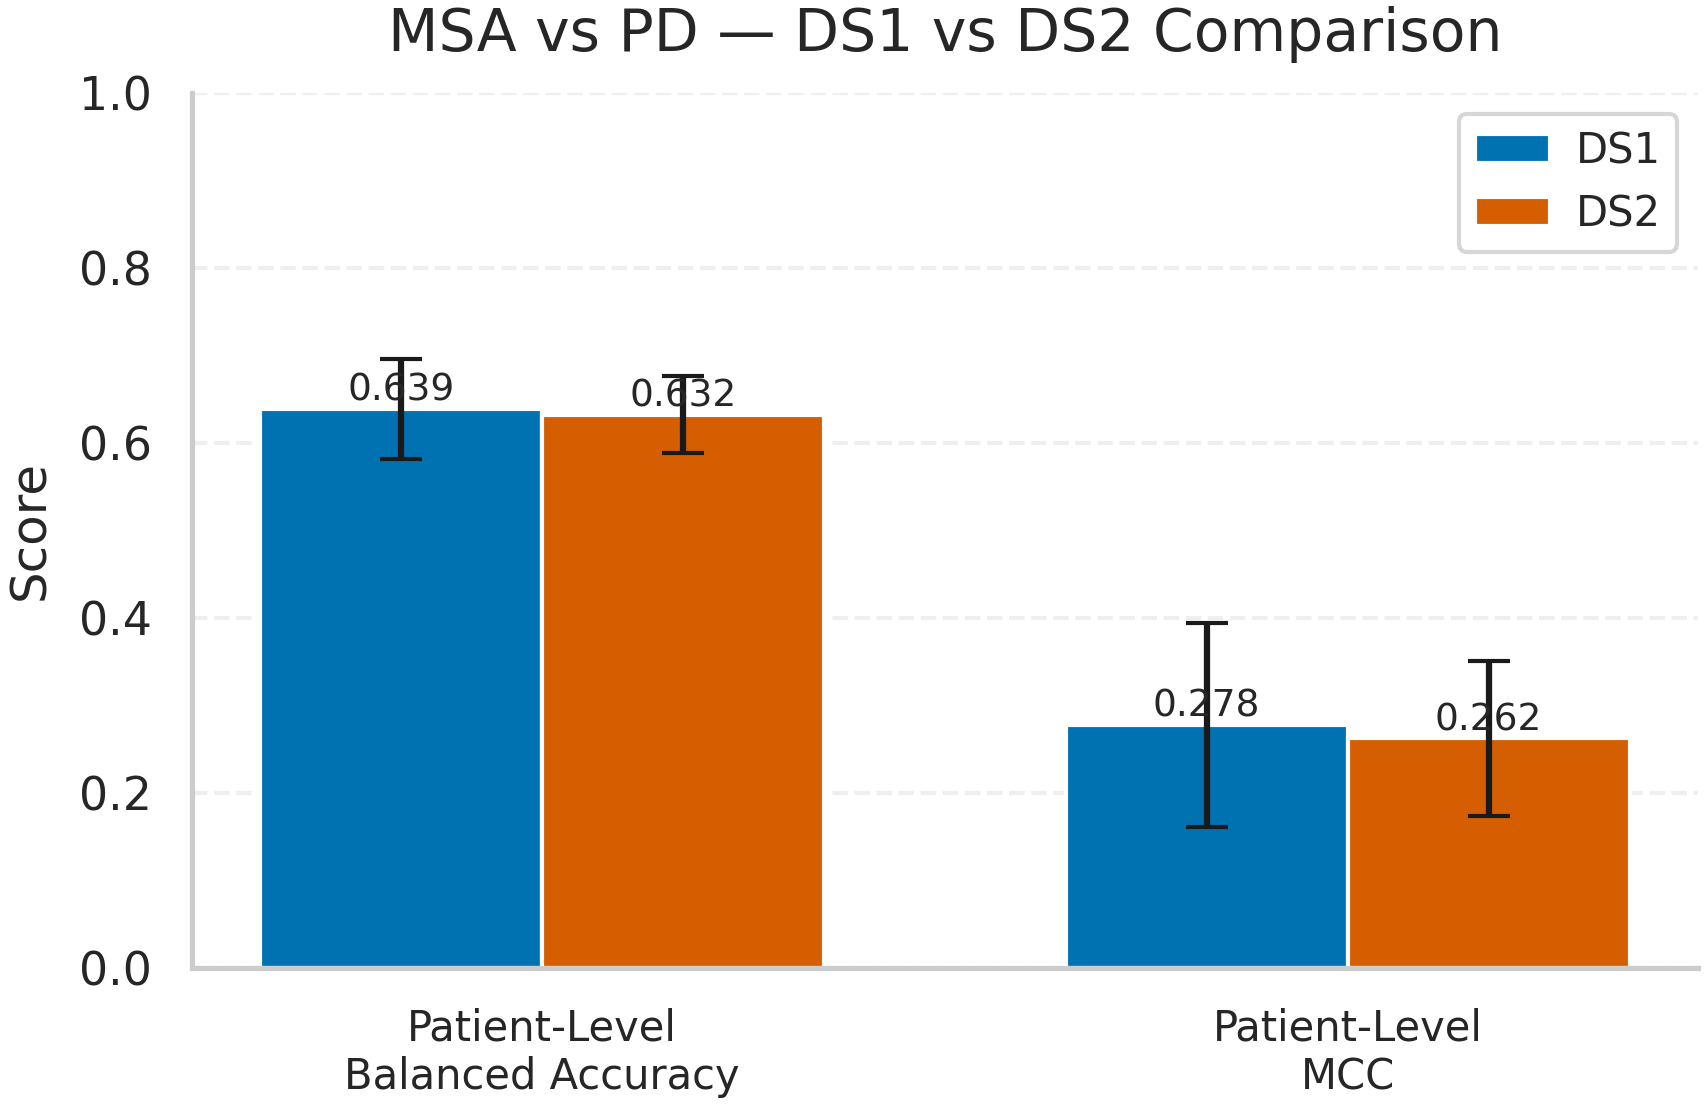

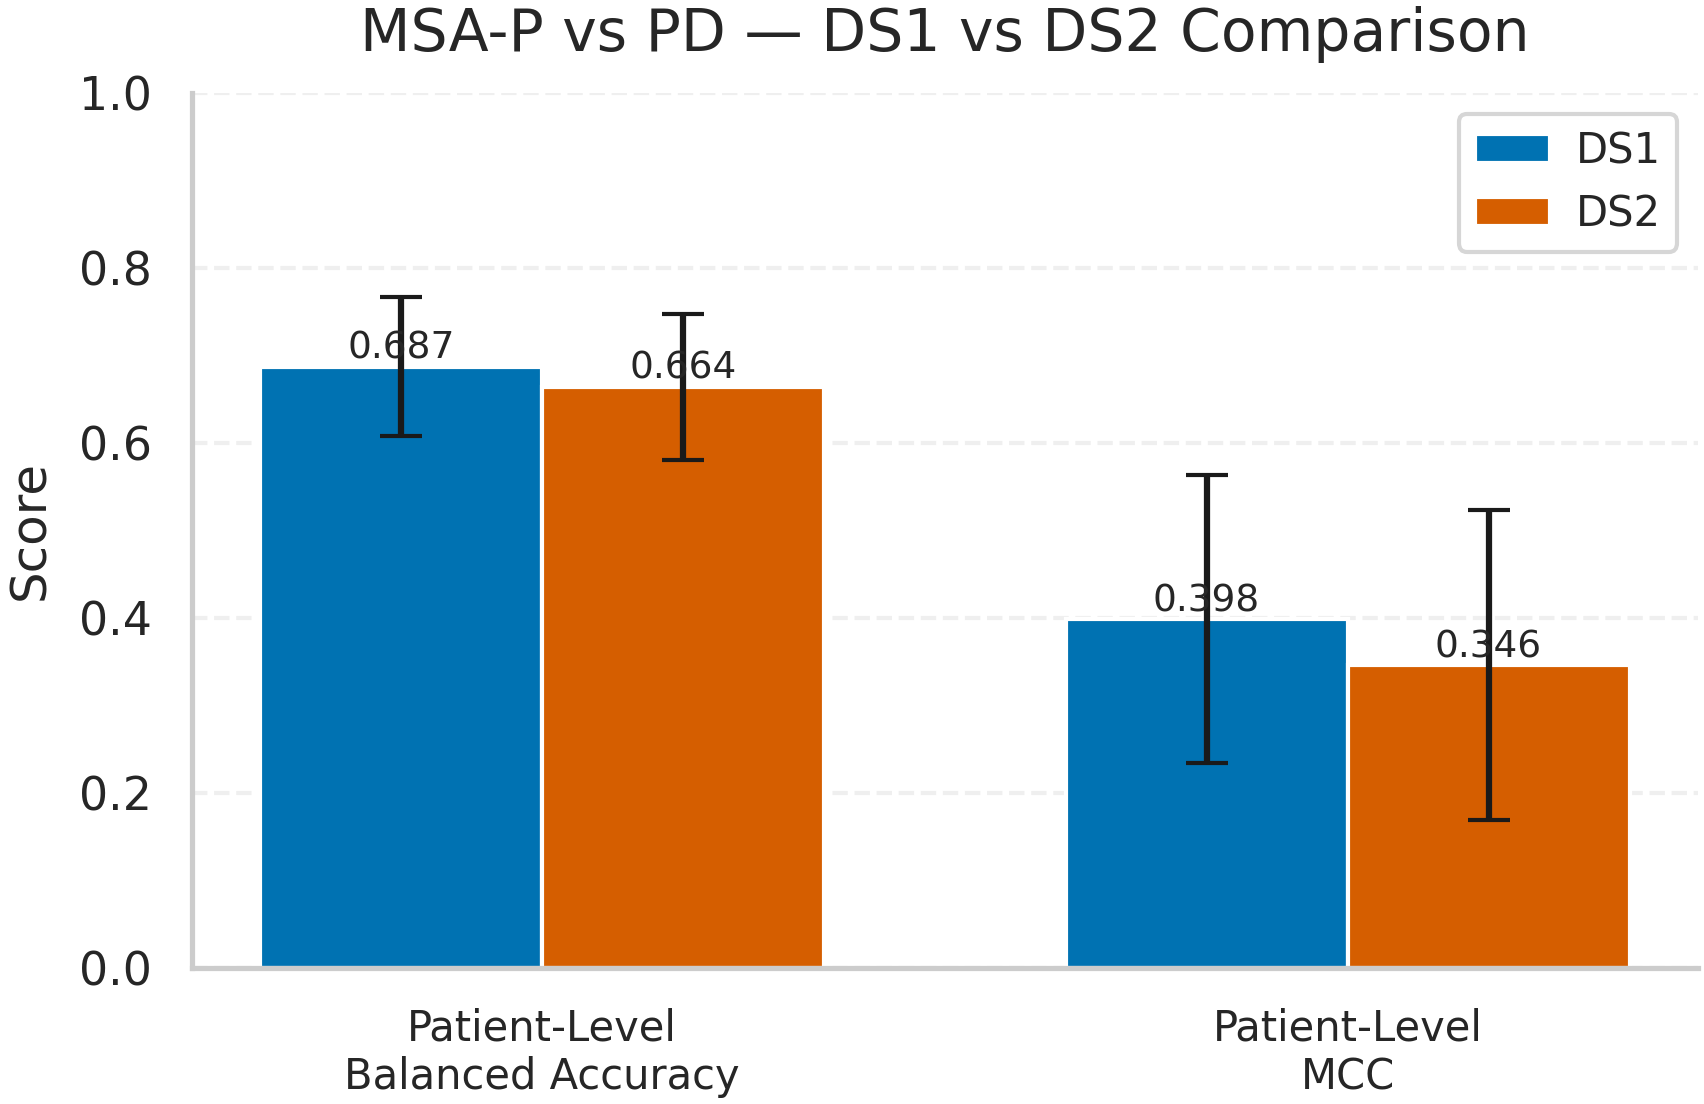

In [158]:
# Import plotting libraries and StyleManager
import sys
import os
# Add parent directory to path to import style module
# Try adding parent directory if style module not found
try:
    from style.style_manager import StyleManager
except ImportError:
    # If import fails, add parent directory to path
    current_dir = os.getcwd()
    if os.path.basename(current_dir) == 'notebooks':
        project_root = os.path.dirname(current_dir)
        sys.path.insert(0, project_root)
    else:
        # Try going up one level
        parent_dir = os.path.dirname(current_dir)
        sys.path.insert(0, parent_dir)
    from style.style_manager import StyleManager
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Determine project root and initialize style with correct paths
current_dir = os.getcwd()
if os.path.basename(current_dir) == 'notebooks':
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

mplstyle_path = os.path.join(project_root, 'style', 'thesis_style.mplstyle')
sm = StyleManager(mplstyle_path=mplstyle_path)
sm.activate()

# Create output directory if it doesn't exist
output_dir = "images/image_analysis"
os.makedirs(output_dir, exist_ok=True)

def extract_metrics_for_comparison(df_ds1, df_ds2, task_name):
    """
    Extract and aggregate patient-level major metrics from two dataframes
    for DS1 vs DS2 comparison.
    
    Parameters
    ----------
    df_ds1 : pandas.DataFrame
        DataFrame containing DS1 results
    df_ds2 : pandas.DataFrame
        DataFrame containing DS2 results
    task_name : str
        Name of the classification task (for display)
    
    Returns
    -------
    dict
        Dictionary containing aggregated metrics for both datasets
    """
    metrics_to_extract = {
        'patient_major_bal_acc': {
            'mean_col': 'mean_patient_major_bal_acc',
            'std_col': 'std_patient_major_bal_acc',
            'label': 'Patient-Level\nBalanced Accuracy'
        },
        'patient_major_mcc': {
            'mean_col': 'mean_patient_major_mcc',
            'std_col': 'std_patient_major_mcc',
            'label': 'Patient-Level\nMCC'
        }
    }
    
    results = {
        'ds1': {},
        'ds2': {},
        'labels': []
    }
    
    for metric_key, metric_info in metrics_to_extract.items():
        mean_col = metric_info['mean_col']
        std_col = metric_info['std_col']
        label = metric_info['label']
        
        # DS1 metrics
        ds1_mean = df_ds1[mean_col].mean()
        ds1_std = df_ds1[mean_col].std()
        
        # DS2 metrics
        ds2_mean = df_ds2[mean_col].mean()
        ds2_std = df_ds2[mean_col].std()
        
        results['ds1'][metric_key] = {'mean': ds1_mean, 'std': ds1_std}
        results['ds2'][metric_key] = {'mean': ds2_mean, 'std': ds2_std}
        results['labels'].append(label)
    
    return results


def create_comparison_figure(results_dict, title, filename):
    """
    Create a grouped bar plot comparing DS1 vs DS2 metrics.
    
    Parameters
    ----------
    results_dict : dict
        Dictionary containing aggregated metrics from extract_metrics_for_comparison
    title : str
        Figure title
    filename : str
        Output filename
    """
    # Prepare data for plotting
    metrics = ['patient_major_bal_acc', 'patient_major_mcc']
    x_labels = results_dict['labels']
    
    ds1_means = [results_dict['ds1'][m]['mean'] for m in metrics]
    ds1_stds = [results_dict['ds1'][m]['std'] for m in metrics]
    ds2_means = [results_dict['ds2'][m]['mean'] for m in metrics]
    ds2_stds = [results_dict['ds2'][m]['std'] for m in metrics]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Set positions for bars
    x = np.arange(len(x_labels))
    width = 0.35
    
    # Create bars
    bars1 = ax.bar(x - width/2, ds1_means, width, yerr=ds1_stds, 
                   label='DS1', capsize=5, color=sm.palette[0])
    bars2 = ax.bar(x + width/2, ds2_means, width, yerr=ds2_stds, 
                   label='DS2', capsize=5, color=sm.palette[1])
    
    # Customize plot
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, fontsize=10)
    ax.legend(frameon=True, loc='best', fontsize=10)
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.0])
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    
    # Save figure
    output_path = os.path.join(output_dir, filename)
    sm.savefig(output_path)
    print(f"Figure saved to {output_path}")


# Extract metrics for Fig A1: MSA vs PD
print("Creating Fig A1: MSA vs PD — DS1 vs DS2")
results_msa = extract_metrics_for_comparison(
    df_ds1_msa, df_ds2_msa, "MSA vs PD"
)
create_comparison_figure(
    results_msa,
    "MSA vs PD — DS1 vs DS2 Comparison",
    "Fig_A1_MSA_vs_PD_DS1_vs_DS2.png"
)

# Extract metrics for Fig A2: MSA-P vs PD
print("\nCreating Fig A2: MSA-P vs PD — DS1 vs DS2")
results_msap = extract_metrics_for_comparison(
    df_ds1_msap, df_ds2_msap, "MSA-P vs PD"
)

create_comparison_figure(
    results_msap,
    "MSA-P vs PD — DS1 vs DS2 Comparison",
    "Fig_A2_MSAP_vs_PD_DS1_vs_DS2.png"
)
